In [ ]:
# old, to be deleted
# use this cell to create events with only start coordinates

import pandas as pd
import numpy as np
import json

def create_player_heatmaps(playerId, season, teamId, event_df, minutes_df):
    """
    Create heatmaps for a player's events in a specific season and team.

    Args:
        playerId (int): Player ID.
        season (str): Season identifier.
        teamId (int): Team ID.
        event_df (pd.DataFrame): DataFrame containing event data (e.g., tackles.csv).
        minutes_df (pd.DataFrame): DataFrame containing minutes-played data (e.g., minutes-played.csv).

    Returns:
        list: A list of dictionaries, each containing a heatmap and the list of contributing match IDs.
    """
    # Filter minutes-played data for the specific player/team/season
    player_minutes = minutes_df[
        (minutes_df['playerId'] == playerId) & 
        (minutes_df['season'] == season) & 
        (minutes_df['teamId'] == teamId)
    ]

    # Calculate total minutes and determine the number of heatmaps needed
    total_minutes = player_minutes['minutesPlayed'].sum()
    match_minutes = player_minutes[['matchId', 'minutesPlayed']].values.tolist()
    num_heatmaps = max(1, -(-total_minutes // 450))  # Ceiling of total_minutes / 450
    target_threshold = total_minutes / num_heatmaps

    # Filter event data for the player
    event_type = event_df[
        (event_df['playerId'] == playerId) & 
        (event_df['season'] == season) & 
        (event_df['teamId'] == teamId)
    ]

    # Initialize variables
    heatmaps = []
    current_heatmap = np.zeros((35, 23))  # 35x23 grid
    accumulated_minutes = 0
    current_match_ids = []  # Track match IDs contributing to the current heatmap

    for match_id, minutes in match_minutes:
        # Filter events for the current match
        match_events = event_type[event_type['matchId'] == match_id]

        # Map events to the 35x23 grid based on x, y coordinates
        for _, event in match_events.iterrows():
            x, y = event['x'], event['y']
            
            # Skip event if x or y is NaN
            if pd.isna(x) or pd.isna(y):
                continue

            grid_x = int(x // (105 / 35))  # Map x-coordinate to grid
            grid_y = int(y // (69 / 23))   # Map y-coordinate to grid

            # Ensure the indices are within bounds
            grid_x = min(grid_x, 34)  # Ensure grid_x is within 0-34
            grid_y = min(grid_y, 22)  # Ensure grid_y is within 0-22

            # Increment heatmap cell
            current_heatmap[grid_x, grid_y] += 1

        # Add match ID and minutes to accumulated totals
        accumulated_minutes += minutes
        current_match_ids.append(match_id)  # Track the match ID

        # Check if we need to finalize the current heatmap
        if accumulated_minutes > target_threshold:
            remaining_minutes = total_minutes - accumulated_minutes

            if remaining_minutes >= 270:  # Avoid creating too small heatmaps
                # Append the current heatmap and contributing match IDs
                heatmaps.append({
                    'heatmap': current_heatmap.copy(),
                    'matchIds': current_match_ids.copy()
                })

                # Reset for the next heatmap
                accumulated_minutes = 0
                current_heatmap = np.zeros((35, 23))
                current_match_ids = []
                num_heatmaps -= 1
                target_threshold = total_minutes / num_heatmaps if num_heatmaps > 0 else 0

    # Add the last heatmap if necessary
    if np.sum(current_heatmap) > 0:
        heatmaps.append({
            'heatmap': current_heatmap.copy(),
            'matchIds': current_match_ids.copy()
        })

    return heatmaps

def save_heatmaps_to_csv(playerId, season, teamId, event_df, minutes_df, csv_filename):
    """
    Generate and save heatmaps for a specific player/team/season combination to a CSV file.

    Args:
        playerId (int): Player ID.
        season (str): Season identifier.
        teamId (int): Team ID.
        event_df (pd.DataFrame): DataFrame containing event data (e.g., tackles.csv).
        minutes_df (pd.DataFrame): DataFrame containing minutes-played data (e.g., minutes-played.csv).
        csv_filename (str): Path to the CSV file to store the heatmaps.
    """
    # Generate heatmaps
    heatmaps = create_player_heatmaps(playerId, season, teamId, event_df, minutes_df)

    # Prepare rows for the CSV
    rows = []
    for heatmap_entry in heatmaps:
        rows.append({
            'playerId': playerId,
            'teamId': teamId,
            'season': season,
            'matchIds': json.dumps(heatmap_entry['matchIds']),  # Serialize match IDs as JSON
            'heatmap': json.dumps(heatmap_entry['heatmap'].tolist())  # Serialize heatmap as JSON
        })

    # Write to CSV
    df = pd.DataFrame(rows)
    if not pd.io.common.file_exists(csv_filename):
        df.to_csv(csv_filename, mode='w', index=False)
    else:
        df.to_csv(csv_filename, mode='a', header=False, index=False)

def generate_player_team_seasons(minutes_df):
    """
    Generate a list of unique player/team/season combinations from the minutes-played data.

    Args:
        minutes_df (pd.DataFrame): DataFrame containing minutes-played data.

    Returns:
        list: A list of tuples containing playerId, season, and teamId combinations.
    """
    # Extract unique combinations of playerId, season, and teamId
    player_team_seasons = minutes_df[['playerId', 'season', 'teamId']].drop_duplicates()

    # Convert the DataFrame into a list of tuples
    return list(player_team_seasons.itertuples(index=False, name=None))

event_file = "aerial.csv" # use csv file relative to the desired event
minutes_file = "minutes-played_filtered.csv"
csv_filename = "aerial_heatmaps.csv"

# Load data once
event_df = pd.read_csv(event_file)
minutes_df = pd.read_csv(minutes_file)

# Generate the list of player/team/season combinations dynamically
player_team_seasons = generate_player_team_seasons(minutes_df)

# Generate and save heatmaps for each combination
for playerId, season, teamId in player_team_seasons:
    save_heatmaps_to_csv(playerId, season, teamId, event_df, minutes_df, csv_filename)

print("Heatmaps saved to CSV file.")


In [ ]:
# old, to be deleted
# this cell creates heatmaps for starting and ending locations, so it should be used for passes and carries

import pandas as pd
import numpy as np
import json

def create_player_heatmaps(playerId, season, teamId, event_df, minutes_df):
    """
    Create heatmaps for a player's events in a specific season and team.

    Args:
        playerId (int): Player ID.
        season (str): Season identifier.
        teamId (int): Team ID.
        event_df (pd.DataFrame): DataFrame containing event data (e.g., passes.csv).
        minutes_df (pd.DataFrame): DataFrame containing minutes-played data.

    Returns:
        list: A list of dictionaries, each containing start and end heatmaps and the contributing match IDs.
    """
    player_minutes = minutes_df[
        (minutes_df['playerId'] == playerId) &
        (minutes_df['season'] == season) &
        (minutes_df['teamId'] == teamId)
    ]
    total_minutes = player_minutes['minutesPlayed'].sum()
    match_minutes = player_minutes[['matchId', 'minutesPlayed']].values.tolist()
    num_heatmaps = max(1, -(-total_minutes // 450))  # Ceiling of total_minutes / 450
    target_threshold = total_minutes / num_heatmaps

    event_type = event_df[
        (event_df['playerId'] == playerId) &
        (event_df['season'] == season) &
        (event_df['teamId'] == teamId)
    ]

    heatmaps = []
    current_start_heatmap = np.zeros((35, 23))
    current_end_heatmap = np.zeros((35, 23))
    accumulated_minutes = 0
    current_match_ids = []

    for match_id, minutes in match_minutes:
        match_events = event_type[event_type['matchId'] == match_id]

        for _, event in match_events.iterrows():
            x, y = event['x'], event['y']
            endX, endY = event.get('endX'), event.get('endY')

            if pd.isna(x) or pd.isna(y) or pd.isna(endX) or pd.isna(endY):
                continue

            grid_x = min(int(x // (105 / 35)), 34)
            grid_y = min(int(y // (69 / 23)), 22)
            end_grid_x = min(int(endX // (105 / 35)), 34)
            end_grid_y = min(int(endY // (69 / 23)), 22)

            current_start_heatmap[grid_x, grid_y] += 1
            current_end_heatmap[end_grid_x, end_grid_y] += 1

        accumulated_minutes += minutes
        current_match_ids.append(match_id)

        if accumulated_minutes > target_threshold:
            remaining_minutes = total_minutes - accumulated_minutes
            if remaining_minutes >= 270:
                heatmaps.append({
                    'start-heatmap': current_start_heatmap.copy(),
                    'end-heatmap': current_end_heatmap.copy(),
                    'matchIds': current_match_ids.copy()
                })
                accumulated_minutes = 0
                current_start_heatmap = np.zeros((35, 23))
                current_end_heatmap = np.zeros((35, 23))
                current_match_ids = []
                num_heatmaps -= 1
                target_threshold = total_minutes / num_heatmaps if num_heatmaps > 0 else 0

    if np.sum(current_start_heatmap) > 0 or np.sum(current_end_heatmap) > 0:
        heatmaps.append({
            'start-heatmap': current_start_heatmap.copy(),
            'end-heatmap': current_end_heatmap.copy(),
            'matchIds': current_match_ids.copy()
        })

    return heatmaps

def save_heatmaps_to_csv(playerId, season, teamId, event_df, minutes_df, csv_filename):
    heatmaps = create_player_heatmaps(playerId, season, teamId, event_df, minutes_df)

    rows = []
    for heatmap_entry in heatmaps:
        rows.append({
            'playerId': playerId,
            'teamId': teamId,
            'season': season,
            'matchIds': json.dumps(heatmap_entry['matchIds']),
            'start-heatmap': json.dumps(heatmap_entry['start-heatmap'].tolist()),
            'end-heatmap': json.dumps(heatmap_entry['end-heatmap'].tolist())
        })

    df = pd.DataFrame(rows)
    if not pd.io.common.file_exists(csv_filename):
        df.to_csv(csv_filename, mode='w', index=False)
    else:
        df.to_csv(csv_filename, mode='a', header=False, index=False)

def generate_player_team_seasons(minutes_df):
    """
    Generate a list of unique player/team/season combinations from the minutes-played data.

    Args:
        minutes_df (pd.DataFrame): DataFrame containing minutes-played data.

    Returns:
        list: A list of tuples containing playerId, season, and teamId combinations.
    """
    # Extract unique combinations of playerId, season, and teamId
    player_team_seasons = minutes_df[['playerId', 'season', 'teamId']].drop_duplicates()

    # Convert the DataFrame into a list of tuples
    return list(player_team_seasons.itertuples(index=False, name=None))

event_file = "open-play-passes.csv" # use csv file relative to the desired event
minutes_file = "minutes-played_filtered.csv"
csv_filename = "passes_start-end_heatmaps.csv"

# Load data once
event_df = pd.read_csv(event_file)
minutes_df = pd.read_csv(minutes_file)

# Generate the list of player/team/season combinations dynamically
player_team_seasons = generate_player_team_seasons(minutes_df)

# Generate and save heatmaps for each combination
for playerId, season, teamId in player_team_seasons:
    save_heatmaps_to_csv(playerId, season, teamId, event_df, minutes_df, csv_filename)

print("Heatmaps saved to CSV file.")

In [ ]:
# Use this to create a sparse heatmap representation

import pandas as pd
import numpy as np
import json

def create_sparse_heatmaps(playerId, season, teamId, event_df, minutes_df):
    """
    Create sparse heatmaps for a player's events in a specific season and team.

    Args:
        playerId (int): Player ID.
        season (str): Season identifier.
        teamId (int): Team ID.
        event_df (pd.DataFrame): DataFrame containing event data (e.g., tackles.csv).
        minutes_df (pd.DataFrame): DataFrame containing minutes-played data (e.g., minutes-played.csv).

    Returns:
        list: A list of dictionaries, each containing a sparse heatmap and the list of contributing match IDs.
    """
    # Filter minutes-played data for the specific player/team/season
    player_minutes = minutes_df[
        (minutes_df['playerId'] == playerId) & 
        (minutes_df['season'] == season) & 
        (minutes_df['teamId'] == teamId)
    ]

    # Calculate total minutes and determine the number of heatmaps needed
    total_minutes = player_minutes['minutesPlayed'].sum()
    match_minutes = player_minutes[['matchId', 'minutesPlayed']].values.tolist()
    num_heatmaps = max(1, -(-total_minutes // 450))  # Ceiling of total_minutes / 450
    target_threshold = total_minutes / num_heatmaps

    # Filter event data for the player
    event_type = event_df[
        (event_df['playerId'] == playerId) & 
        (event_df['season'] == season) & 
        (event_df['teamId'] == teamId)
    ]

    # Initialize variables
    heatmaps = []
    sparse_representation = {}
    accumulated_minutes = 0
    current_match_ids = []  # Track match IDs contributing to the current heatmap

    for match_id, minutes in match_minutes:
        # Filter events for the current match
        match_events = event_type[event_type['matchId'] == match_id]

        # Map events to the sparse dictionary based on (startX, startY) -> (endX, endY) coordinates
        for _, event in match_events.iterrows():
            x, y = event['x'], event['y']
            endX, endY = event.get('endX'), event.get('endY')

            # Skip event if any coordinate is NaN
            if pd.isna(x) or pd.isna(y) or pd.isna(endX) or pd.isna(endY):
                continue

            # Map coordinates to 35x23 grid
            startX = int(x // (105 / 35))
            startY = int(y // (69 / 23))
            endX = int(endX // (105 / 35))
            endY = int(endY // (69 / 23))

            # Ensure indices are within bounds
            startX, startY = min(startX, 34), min(startY, 22)
            endX, endY = min(endX, 34), min(endY, 22)

            # Update the sparse representation
            key = (startX, startY, endX, endY)
            sparse_representation[key] = sparse_representation.get(key, 0) + 1

        # Add match ID and minutes to accumulated totals
        accumulated_minutes += minutes
        current_match_ids.append(match_id)

        # Check if we need to finalize the current heatmap
        if accumulated_minutes > target_threshold:
            remaining_minutes = total_minutes - accumulated_minutes

            if remaining_minutes >= 270:  # Avoid creating too small heatmaps
                # Append the current sparse representation and contributing match IDs
                heatmaps.append({
                    'sparseHeatmap': sparse_representation.copy(),
                    'matchIds': current_match_ids.copy()
                })

                # Reset for the next heatmap
                accumulated_minutes = 0
                sparse_representation = {}
                current_match_ids = []
                num_heatmaps -= 1
                target_threshold = total_minutes / num_heatmaps if num_heatmaps > 0 else 0

    # Add the last sparse heatmap if necessary
    if sparse_representation:
        heatmaps.append({
            'sparseHeatmap': sparse_representation.copy(),
            'matchIds': current_match_ids.copy()
        })

    return heatmaps

def save_compact_sparse_heatmaps(playerId, season, teamId, event_df, minutes_df, csv_filename):
    """
    Generate and save compact sparse heatmaps for a specific player/team/season combination to a CSV file.

    Args:
        playerId (int): Player ID.
        season (str): Season identifier.
        teamId (int): Team ID.
        event_df (pd.DataFrame): DataFrame containing event data.
        minutes_df (pd.DataFrame): DataFrame containing minutes-played data.
        csv_filename (str): Path to the CSV file to store the compact sparse heatmaps.
    """
    # Generate sparse heatmaps
    heatmaps = create_sparse_heatmaps(playerId, season, teamId, event_df, minutes_df)

    # Prepare rows for the CSV
    rows = []
    for heatmap_entry in heatmaps:
        sparse_data = [
            {"x": sx, "y": sy, "endX": ex, "endY": ey, "count": c}
            for (sx, sy, ex, ey), c in heatmap_entry['sparseHeatmap'].items()
        ]

        rows.append({
            'playerId': playerId,
            'teamId': teamId,
            'season': season,
            'matchIds': json.dumps(heatmap_entry['matchIds']),  # Serialize match IDs as JSON
            'sparse-heatmap': json.dumps(sparse_data)  # Store sparse heatmap as JSON
        })

    # Write to CSV
    df = pd.DataFrame(rows)
    if not pd.io.common.file_exists(csv_filename):
        df.to_csv(csv_filename, mode='w', index=False)
    else:
        df.to_csv(csv_filename, mode='a', header=False, index=False)

def generate_player_team_seasons(minutes_df):
    """
    Generate a list of unique player/team/season combinations from the minutes-played data.

    Args:
        minutes_df (pd.DataFrame): DataFrame containing minutes-played data.

    Returns:
        list: A list of tuples containing playerId, season, and teamId combinations.
    """
    # Extract unique combinations of playerId, season, and teamId
    player_team_seasons = minutes_df[['playerId', 'season', 'teamId']].drop_duplicates()

    # Convert the DataFrame into a list of tuples
    return list(player_team_seasons.itertuples(index=False, name=None))

event_file = "open-play-passes.csv" # use csv file relative to the desired event
minutes_file = "minutes-played_filtered.csv"
csv_filename = "passes_sparse-representation.csv"

# Load data once
event_df = pd.read_csv(event_file)
minutes_df = pd.read_csv(minutes_file)

# Generate the list of player/team/season combinations dynamically
player_team_seasons = generate_player_team_seasons(minutes_df)

# Generate and save heatmaps for each combination
for playerId, season, teamId in player_team_seasons:
    save_compact_sparse_heatmaps(playerId, season, teamId, event_df, minutes_df, csv_filename)

print("Heatmaps saved to CSV file.")

In [ ]:
# to be improved - sparse heatmap generation with normalization (coordinates and counts)

import pandas as pd
import numpy as np
import json

def create_sparse_heatmaps(playerId, season, teamId, event_df, minutes_df):
    """
    Create sparse heatmaps for a player's events in a specific season and team.

    Args:
        playerId (int): Player ID.
        season (str): Season identifier.
        teamId (int): Team ID.
        event_df (pd.DataFrame): DataFrame containing event data (e.g., tackles.csv).
        minutes_df (pd.DataFrame): DataFrame containing minutes-played data (e.g., minutes-played.csv).

    Returns:
        list: A list of dictionaries, each containing a sparse heatmap and the list of contributing match IDs.
    """
    player_minutes = minutes_df[
        (minutes_df['playerId'] == playerId) & 
        (minutes_df['season'] == season) & 
        (minutes_df['teamId'] == teamId)
    ]

    total_minutes = player_minutes['minutesPlayed'].sum()
    match_minutes = player_minutes[['matchId', 'minutesPlayed']].values.tolist()
    num_heatmaps = max(1, -(-total_minutes // 450))
    target_threshold = total_minutes / num_heatmaps

    event_type = event_df[
        (event_df['playerId'] == playerId) & 
        (event_df['season'] == season) & 
        (event_df['teamId'] == teamId)
    ]

    heatmaps = []
    sparse_representation = {}
    accumulated_minutes = 0
    current_match_ids = []

    for match_id, minutes in match_minutes:
        match_events = event_type[event_type['matchId'] == match_id]

        for _, event in match_events.iterrows():
            x, y = event['x'], event['y']
            endX, endY = event.get('endX'), event.get('endY')

            if pd.isna(x) or pd.isna(y) or pd.isna(endX) or pd.isna(endY):
                continue

            startX = int(x // (105 / 35))
            startY = int(y // (69 / 23))
            endX = int(endX // (105 / 35))
            endY = int(endY // (69 / 23))

            startX, startY = min(startX, 34), min(startY, 22)
            endX, endY = min(endX, 34), min(endY, 22)

            key = (startX, startY, endX, endY)
            sparse_representation[key] = sparse_representation.get(key, 0) + 1

        accumulated_minutes += minutes
        current_match_ids.append(int(match_id))

        if accumulated_minutes > target_threshold:
            remaining_minutes = total_minutes - accumulated_minutes

            if remaining_minutes >= 270:
                heatmaps.append({
                    'sparseHeatmap': sparse_representation.copy(),
                    'matchIds': current_match_ids.copy()
                })

                accumulated_minutes = 0
                sparse_representation = {}
                current_match_ids = []
                num_heatmaps -= 1
                target_threshold = total_minutes / num_heatmaps if num_heatmaps > 0 else 0

    if sparse_representation:
        heatmaps.append({
            'sparseHeatmap': sparse_representation.copy(),
            'matchIds': current_match_ids.copy()
        })

    return heatmaps

def save_sparse_heatmaps(playerId, season, teamId, event_df, minutes_df, csv_filename):
    """
    Generate and save sparse heatmaps for a specific player/team/season combination to a CSV file.

    Args:
        playerId (int): Player ID.
        season (str): Season identifier.
        teamId (int): Team ID.
        event_df (pd.DataFrame): DataFrame containing event data.
        minutes_df (pd.DataFrame): DataFrame containing minutes-played data.
        csv_filename (str): Path to the CSV file to store sparse heatmaps.
    """
    heatmaps = create_sparse_heatmaps(playerId, season, teamId, event_df, minutes_df)

    rows = []
    for heatmap_entry in heatmaps:
        sparse_data = [
            (sx, sy, ex, ey, count)
            for (sx, sy, ex, ey), count in heatmap_entry['sparseHeatmap'].items()
        ]

        rows.append({
            'playerId': playerId,
            'teamId': teamId,
            'season': season,
            'matchIds': json.dumps(heatmap_entry['matchIds']),
            'sparse-heatmap': json.dumps(sparse_data)
        })

    df = pd.DataFrame(rows)
    if not pd.io.common.file_exists(csv_filename):
        df.to_csv(csv_filename, mode='w', index=False)
    else:
        df.to_csv(csv_filename, mode='a', header=False, index=False)

def generate_player_team_seasons(minutes_df):
    return list(minutes_df[['playerId', 'season', 'teamId']].drop_duplicates().itertuples(index=False, name=None))

event_file = "carries.csv"
minutes_file = "minutes-played_filtered.csv"
csv_filename = "carries_normalized-sparse-representation.csv"

event_df = pd.read_csv(event_file)
minutes_df = pd.read_csv(minutes_file)

player_team_seasons = generate_player_team_seasons(minutes_df)

for playerId, season, teamId in player_team_seasons:
    save_sparse_heatmaps(playerId, season, teamId, event_df, minutes_df, csv_filename)

print("Heatmaps saved to CSV file.")

In [ ]:
# testing all heatmaps generation

import pandas as pd
import numpy as np
import json

def create_player_heatmaps(playerId, season, teamId, event_dfs, minutes_df):
    """
    Create heatmaps for a player's events in a specific season and team.

    Args:
        playerId (int): Player ID.
        season (str): Season identifier.
        teamId (int): Team ID.
        event_dfs (dict): Dictionary containing event data for each event type (e.g., passes, tackles).
        minutes_df (pd.DataFrame): DataFrame containing minutes-played data.

    Returns:
        list: A list of dictionaries, each containing heatmaps and contributing match IDs.
    """
    player_minutes = minutes_df[(minutes_df['playerId'] == playerId) &
                                (minutes_df['season'] == season) &
                                (minutes_df['teamId'] == teamId)]

    total_minutes = player_minutes['minutesPlayed'].sum()
    match_minutes = player_minutes[['matchId', 'minutesPlayed']].values.tolist()

    # Calculate number of heatmaps
    num_heatmaps = max(1, -(-total_minutes // 450))  # Ceiling of total_minutes / 450
    target_threshold = total_minutes / num_heatmaps if num_heatmaps > 0 else 0

    # Initialize heatmaps
    heatmaps = []
    accumulated_minutes = 0
    current_match_ids = []

    # Initialize heatmap grids
    event_grids = {event_type: {
        'start': np.zeros((35, 23)),  # 23 rows (vertical), 35 columns (horizontal)
        'end': np.zeros((35, 23)) if event_type in ['passes', 'carries'] else None  # Same grid for 'end' positions
    } for event_type in event_dfs}

    # Process each match's events
    for match_id, minutes in match_minutes:
        match_events = {event_type: event_dfs[event_type][event_dfs[event_type]['matchId'] == match_id]
                        for event_type in event_dfs}

        for event_type, df in match_events.items():
            # Filter the events for the specific playerId
            player_events = df[df['playerId'] == playerId]  # Only keep events for the target player
            for _, event in player_events.iterrows():
                x, y = event['x'], event['y']
                

                if pd.isna(x) or pd.isna(y):
                    continue

                # Convert to grid coordinates
                grid_x = min(int(x // 3), 34) 
                grid_y = min(int(y // 3), 22)

                event_grids[event_type]['start'][grid_x, grid_y] += 1

                if event_type in ['passes', 'carries']:
                    endX, endY = event.get('endX'), event.get('endY')
                    if not (pd.isna(endX) or pd.isna(endY)):
                        end_grid_x = min(int(endX // 3), 34)
                        end_grid_y = min(int(endY // 3), 22)
                        event_grids[event_type]['end'][end_grid_x, end_grid_y] += 1
                    else:
                        continue

        accumulated_minutes += minutes
        current_match_ids.append(match_id)

        if accumulated_minutes >= target_threshold:
            # Append current heatmaps
            heatmaps.append({
                'heatmapsId': f"{playerId}-{teamId}-{season}-{len(heatmaps)+1}",
                'playerId': playerId,
                'teamId': teamId,
                'season': season,
                'matchIds': json.dumps(current_match_ids),
                **{
                    f"{event_type}-start-heatmap": json.dumps(event_grids[event_type]['start'].tolist())
                    for event_type in event_grids
                },
                **{
                    f"{event_type}-end-heatmap": json.dumps(event_grids[event_type]['end'].tolist())
                    for event_type in ['passes', 'carries']
                }
            })

            accumulated_minutes = 0
            current_match_ids = []
            event_grids = {event_type: {
                'start': np.zeros((35, 23)),
                'end': np.zeros((35, 23)) if event_type in ['passes', 'carries'] else None
            } for event_type in event_dfs}

    # Handle remaining heatmaps
    if accumulated_minutes > 0:
        heatmaps.append({
            'heatmapsId': f"{playerId}-{teamId}-{season}-{len(heatmaps)+1}",
            'playerId': playerId,
            'teamId': teamId,
            'season': season,
            'matchIds': json.dumps(current_match_ids),
            **{
                f"{event_type}-start-heatmap": json.dumps(event_grids[event_type]['start'].tolist())
                for event_type in event_grids
            },
            **{
                f"{event_type}-end-heatmap": json.dumps(event_grids[event_type]['end'].tolist())
                for event_type in ['passes', 'carries']
            }
        })

    return heatmaps

# Load data files
event_files = {
    'passes': pd.read_csv("open-play-passes.csv"),
    'carries': pd.read_csv("carries.csv"),
    'crosses': pd.read_csv("open-play-crosses.csv"),
    'shots': pd.read_csv("open-play-shots.csv"),
    'recoveries': pd.read_csv("recoveries.csv"),
    'tackles': pd.read_csv("tackles.csv"),
    'take-ons': pd.read_csv("take-ons.csv"),
    'aerial': pd.read_csv("aerial.csv")
}

minutes_df = pd.read_csv("minutes-played_filtered.csv")
csv_filename = "player_heatmaps_test.csv"

# Define specific player/team/season combinations for testing
player_team_seasons = [
    (400036, "2020-2021", 124),  # Player 1
    (115419, "2020-2021", 124),   # Player 2
    (400303, "2020-2021", 260),   # Player 3
    (141392, "2020-2021", 260)   # Player 4
]

# Generate and save heatmaps for each combination
test_rows = []
for playerId, season, teamId in player_team_seasons:
    heatmaps = create_player_heatmaps(playerId, season, teamId, event_files, minutes_df)
    test_rows.extend(heatmaps)

# Save to a test CSV file
pd.DataFrame(test_rows).to_csv(csv_filename, index=False)

print("Test heatmaps saved to CSV file.")

In [1]:
# create all heatmaps at once and split data in smaller files

import pandas as pd
import numpy as np
import json
import os

# Define max file size (in MB)
max_file_size_mb = 256
current_file_size = 0
chunk_counter = 1
test_rows = []

# Function to generate player/team/season combinations
def generate_player_team_seasons(minutes_df):
    player_team_seasons = minutes_df[['playerId', 'season', 'teamId']].drop_duplicates()
    return list(player_team_seasons.itertuples(index=False, name=None))

# Function to create player heatmaps
def create_player_heatmaps(playerId, season, teamId, event_dfs, minutes_df):
    player_minutes = minutes_df[(minutes_df['playerId'] == playerId) & 
                                (minutes_df['season'] == season) & 
                                (minutes_df['teamId'] == teamId)]
    total_minutes = player_minutes['minutesPlayed'].sum()
    match_minutes = player_minutes[['matchId', 'minutesPlayed']].values.tolist()

    # Calculate number of heatmaps
    num_heatmaps = max(1, -(-total_minutes // 450))  # Ceiling of total_minutes / 450
    target_threshold = total_minutes / num_heatmaps if num_heatmaps > 0 else 0

    # Initialize heatmaps
    heatmaps = []
    accumulated_minutes = 0
    current_match_ids = []

    # Initialize heatmap grids
    event_grids = {event_type: {
        'start': np.zeros((35, 23)),  # 23 rows (vertical), 35 columns (horizontal)
        'end': np.zeros((35, 23)) if event_type in ['passes', 'carries'] else None
    } for event_type in event_dfs}

    # Process each match's events
    for match_id, minutes in match_minutes:
        match_events = {event_type: event_dfs[event_type][event_dfs[event_type]['matchId'] == match_id]
                        for event_type in event_dfs}

        for event_type, df in match_events.items():
            player_events = df[df['playerId'] == playerId]  # Only keep events for the target player
            for _, event in player_events.iterrows():
                x, y = event['x'], event['y']

                if pd.isna(x) or pd.isna(y):
                    continue

                # Convert to grid coordinates
                grid_x = min(int(x // 3), 34)
                grid_y = min(int(y // 3), 22)

                event_grids[event_type]['start'][grid_x, grid_y] += 1

                if event_type in ['passes', 'carries']:
                    endX, endY = event.get('endX'), event.get('endY')
                    if not (pd.isna(endX) or pd.isna(endY)):
                        end_grid_x = min(int(endX // 3), 34)
                        end_grid_y = min(int(endY // 3), 22)
                        event_grids[event_type]['end'][end_grid_x, end_grid_y] += 1

        accumulated_minutes += minutes
        current_match_ids.append(match_id)

        if accumulated_minutes >= target_threshold:
            # Append current heatmaps
            heatmaps.append({
                'heatmapsId': f"{playerId}-{teamId}-{season}-{len(heatmaps)+1}",
                'playerId': playerId,
                'teamId': teamId,
                'season': season,
                'matchIds': json.dumps(current_match_ids),
                **{
                    f"{event_type}-start-heatmap": json.dumps(event_grids[event_type]['start'].tolist())
                    for event_type in event_grids
                },
                **{
                    f"{event_type}-end-heatmap": json.dumps(event_grids[event_type]['end'].tolist())
                    for event_type in ['passes', 'carries']
                }
            })

            accumulated_minutes = 0
            current_match_ids = []
            event_grids = {event_type: {
                'start': np.zeros((35, 23)),
                'end': np.zeros((35, 23)) if event_type in ['passes', 'carries'] else None
            } for event_type in event_dfs}

    # Handle remaining heatmaps
    if accumulated_minutes > 0:
        heatmaps.append({
            'heatmapsId': f"{playerId}-{teamId}-{season}-{len(heatmaps)+1}",
            'playerId': playerId,
            'teamId': teamId,
            'season': season,
            'matchIds': json.dumps(current_match_ids),
            **{
                f"{event_type}-start-heatmap": json.dumps(event_grids[event_type]['start'].tolist())
                for event_type in event_grids
            },
            **{
                f"{event_type}-end-heatmap": json.dumps(event_grids[event_type]['end'].tolist())
                for event_type in ['passes', 'carries']
            }
        })

    return heatmaps

# Load data files
event_files = {
    'passes': pd.read_csv("open-play-passes.csv"),
    'carries': pd.read_csv("carries.csv"),
    'crosses': pd.read_csv("open-play-crosses.csv"),
    'shots': pd.read_csv("open-play-shots.csv"),
    'recoveries': pd.read_csv("recoveries.csv"),
    'tackles': pd.read_csv("tackles.csv"),
    'take-ons': pd.read_csv("take-ons.csv"),
    'aerial': pd.read_csv("aerial.csv")
}

minutes_df = pd.read_csv("minutes-played_filtered.csv")

# Generate player/team/season combinations from the minutes-played data
player_team_seasons = generate_player_team_seasons(minutes_df)

# Generate and save heatmaps for each combination
for playerId, season, teamId in player_team_seasons:  # slicing to test with first 5
    heatmaps = create_player_heatmaps(playerId, season, teamId, event_files, minutes_df)
    test_rows.extend(heatmaps)

    # Check if current file size exceeds the threshold
    if current_file_size > max_file_size_mb * 1024 * 1024:
        # Save the current chunk
        chunk_filename = f"heatmaps_chunk_{chunk_counter}.csv"
        pd.DataFrame(test_rows).to_csv(chunk_filename, index=False)
        print(f"Saved chunk {chunk_counter} to {chunk_filename}")
        chunk_counter += 1

        # Reset test rows and current file size
        test_rows = []
        current_file_size = 0

    # Estimate the size of the current data in bytes
    current_file_size = sum([len(str(row)) for row in test_rows])

# Save the last chunk if any heatmaps are left
if test_rows:
    chunk_filename = f"heatmaps_chunk_{chunk_counter}.csv"
    pd.DataFrame(test_rows).to_csv(chunk_filename, index=False)
    print(f"Saved chunk {chunk_counter} to {chunk_filename}")

C:\Users\Francesco\AppData\Local\Temp\ipykernel_5888\798832735.py:118: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  'passes': pd.read_csv("open-play-passes.csv"),
C:\Users\Francesco\AppData\Local\Temp\ipykernel_5888\798832735.py:119: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  'carries': pd.read_csv("carries.csv"),
C:\Users\Francesco\AppData\Local\Temp\ipykernel_5888\798832735.py:120: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  'crosses': pd.read_csv("open-play-crosses.csv"),
C:\Users\Francesco\AppData\Local\Temp\ipykernel_5888\798832735.py:122: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  'recoveries': pd.read_csv("recoveries.csv"),
C:\Users\Francesco\AppData\Local\Temp\ipykernel_5888\798832735.py:123: DtypeWarning: Columns (0) have mixed types. Specify dtype

Saved chunk 1 to heatmaps_chunk_1.csv
Saved chunk 2 to heatmaps_chunk_2.csv
Saved chunk 3 to heatmaps_chunk_3.csv
Saved chunk 4 to heatmaps_chunk_4.csv
Saved chunk 5 to heatmaps_chunk_5.csv
Saved chunk 6 to heatmaps_chunk_6.csv
Saved chunk 7 to heatmaps_chunk_7.csv
Saved chunk 8 to heatmaps_chunk_8.csv
Saved chunk 9 to heatmaps_chunk_9.csv
Saved chunk 10 to heatmaps_chunk_10.csv
Saved chunk 11 to heatmaps_chunk_11.csv
Saved chunk 12 to heatmaps_chunk_12.csv
Saved chunk 13 to heatmaps_chunk_13.csv
Saved chunk 14 to heatmaps_chunk_14.csv
Saved chunk 15 to heatmaps_chunk_15.csv
Saved chunk 16 to heatmaps_chunk_16.csv
Saved chunk 17 to heatmaps_chunk_17.csv
Saved chunk 18 to heatmaps_chunk_18.csv
Saved chunk 19 to heatmaps_chunk_19.csv
Saved chunk 20 to heatmaps_chunk_20.csv
Saved chunk 21 to heatmaps_chunk_21.csv
Saved chunk 22 to heatmaps_chunk_22.csv
Saved chunk 23 to heatmaps_chunk_23.csv
Saved chunk 24 to heatmaps_chunk_24.csv


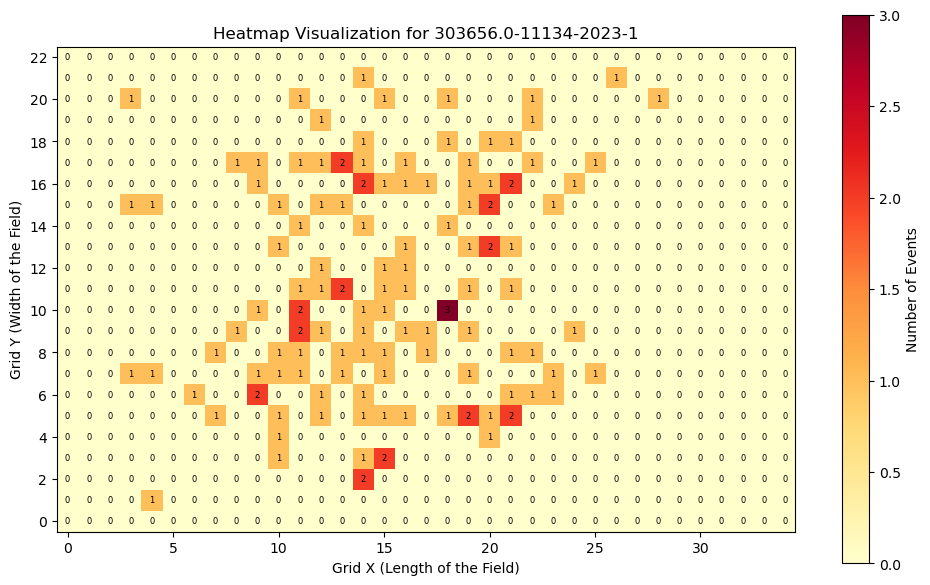

In [2]:
# Visualize example heatmap

import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the generated CSV file
csv_filename = "_Heatmaps/heatmaps_chunk_24.csv"
heatmaps_df = pd.read_csv(csv_filename)

# Filter for the specific heatmapsId
heatmaps_id = "303656.0-11134-2023-1"
specific_row = heatmaps_df[heatmaps_df['heatmapsId'] == heatmaps_id]

if not specific_row.empty:
    # Extract the JSON string from the 'shots-start-heatmap' column
    heatmap_json = specific_row.iloc[0]['passes-start-heatmap']

    # Convert the JSON string to a Python list
    heatmap_grid = np.array(json.loads(heatmap_json))  # Convert to NumPy array for visualization

    # Transpose the heatmap for proper horizontal pitch orientation
    heatmap_grid = heatmap_grid.T

    # Create a visualization using Matplotlib
    plt.figure(figsize=(10, 6))
    plt.imshow(heatmap_grid, cmap='YlOrRd', interpolation='nearest', origin='lower')
    plt.colorbar(label="Number of Events")
    plt.title(f"Heatmap Visualization for {heatmaps_id}")
    plt.xlabel("Grid X (Length of the Field)")
    plt.ylabel("Grid Y (Width of the Field)")
    plt.xticks(ticks=range(0, 35, 5), labels=range(0, 35, 5))  # Adjust for grid length
    plt.yticks(ticks=range(0, 23, 2), labels=range(0, 23, 2))  # Adjust for grid width

    # Annotate each cell with the event count
    for x in range(heatmap_grid.shape[0]):
        for y in range(heatmap_grid.shape[1]):
            plt.text(y, x, int(heatmap_grid[x, y]), ha='center', va='center', color='black', fontsize=6)

    plt.tight_layout()
    plt.show()
else:
    print(f"No data found for heatmapsId {heatmaps_id}")